## 1. Imports & Config.

In [104]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.wcs import WCS
from astropy.io import fits
from astropy.time import Time
from scipy import ndimage


data_dir = os.path.join(os.getcwd(), 'data')

obsid = '1342203292'  # observation id

level = 'level2_5'

lambda_um = 500

array = {250: 'PSW', 350: 'PMW', 500: 'PLW'}[lambda_um]

# possible types:
#   extd: extended-source calibrated (MJy/sr)
#   hires: extended-source calibrated, hi-res (Richardson-Lucy deconvolution, MJy/sr)
#   psrc: point-source calibrated (Jy/beam)

type = 'hires'

product = f'{type}{array}'

obs_dir = os.path.join(data_dir, obsid)
level_dir = os.path.join(obs_dir, level)
prod_dir = os.path.join(level_dir, product)

## 2. Load Image Data

In [105]:
# each product directory contains a single .fits file
prod_fnames = os.listdir(prod_dir)
assert len(prod_fnames) == 1, "only one file expected"
assert prod_fnames[0].endswith('.fits'), "file should be in .fits format"

fits_filename = os.path.join(prod_dir, prod_fnames[0])

# open the only file in the directory
hdul = fits.open(fits_filename)  # Header Data Unit list
hdul.info()

Filename: C:\Users\Jonah\PycharmProjects\spire_blasttng_diff\data\1342203292\level2_5\hiresPLW\hspireplw1342203291_25hirespxmp_1462481003485.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     163   ()      
  1  image         1 ImageHDU        49   (1776, 1836)   float64   
  2  cfv           1 ImageHDU        47   (1776, 1836)   float64   
  3  coverage      1 ImageHDU        49   (1776, 1836)   float64   
  4  History       1 ImageHDU        23   ()      
  5  HistoryScript    1 BinTableHDU     39   10R x 1C   [326A]   
  6  HistoryTasks    1 BinTableHDU     46   3R x 4C   [1K, 16A, 1K, 9A]   
  7  HistoryParameters    1 BinTableHDU     74   25R x 10C   [1K, 18A, 13A, 196A, 1L, 1K, 1L, 47A, 11A, 28A]   


## 3. Plot Images

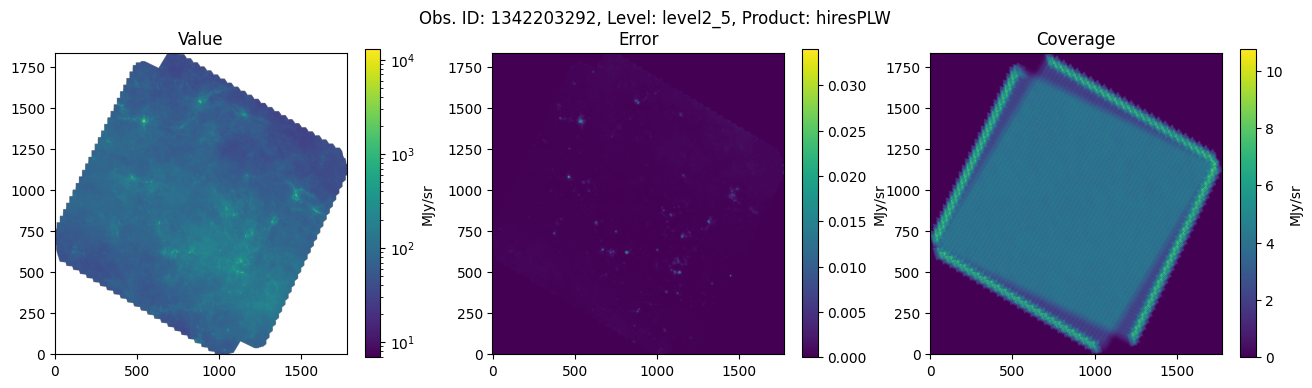

In [106]:
log_norm = colors.LogNorm()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(16, 4))
fig.suptitle(f"Obs. ID: {obsid}, Level: {level}, Product: {product}")

img = hdul[1].data
ax1.set_title("Value")
fig1 = ax1.imshow(img, cmap='viridis', norm=log_norm, origin='lower')
plt.colorbar(fig1, ax=ax1, label="MJy/sr")

error = hdul[2].data
ax2.set_title("Error")
fig2 = ax2.imshow(error, cmap='viridis', origin='lower')
plt.colorbar(fig2, ax=ax2, label="MJy/sr")

coverage = hdul[3].data
ax3.set_title("Coverage")
fig3 = ax3.imshow(coverage, cmap='viridis', origin='lower')
plt.colorbar(fig3, ax=ax3, label="MJy/sr")

plt.show()

# hdul[1].header

## 4. Locate Target Object

In [107]:
rcw92_coord = SkyCoord.from_name('RCW 92')
wcs = WCS(fits_filename)

Set MJD-END to 55430.205020 from DATE-END'. [astropy.wcs.wcs]


## 5. Create Plot Window

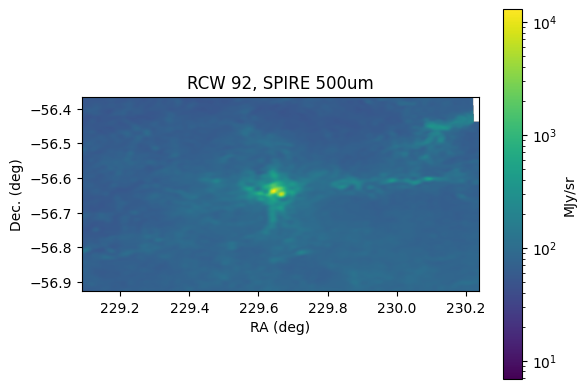

In [108]:
def get_value(x_coords, y_coords):
    rows, cols = wcs.world_to_pixel(SkyCoord(ra=x_coords, dec=y_coords))
    return img[np.floor(cols).astype(int), np.floor(rows).astype(int)]

scan_center = SkyCoord(ra=231.5, dec=-56.25, unit='deg')

width = 1.1475*u.deg
height = 0.5625*u.deg

ra_min = rcw92_coord.ra - width/2
ra_max = rcw92_coord.ra + width/2

dec_min = rcw92_coord.dec - height/2
dec_max = rcw92_coord.dec + height/2

resolution = 0.001  # degrees

x = np.arange(ra_min.deg, ra_max.deg, resolution)*u.deg
y = np.arange(dec_min.deg, dec_max.deg, resolution)*u.deg
X, Y = np.meshgrid(x, y)  # Create 2D grids for x and y

out_img = get_value(X, Y)

plt.imshow(
    out_img,
    extent=(ra_min.deg, ra_max.deg, dec_min.deg, dec_max.deg),
    norm=log_norm,
    cmap='viridis',
    origin='lower'
)
plt.title("RCW 92, SPIRE 500um")
plt.colorbar(label="MJy/sr")
plt.xlabel("RA (deg)")
plt.ylabel("Dec. (deg)")
plt.show()

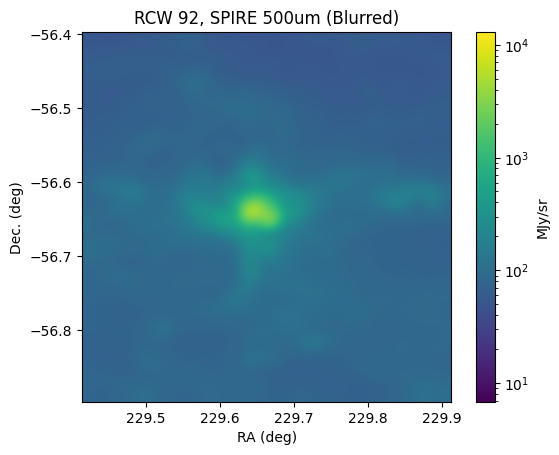

In [109]:
width = 0.5*u.deg
height = 0.5*u.deg

ra_min = rcw92_coord.ra - width/2
ra_max = rcw92_coord.ra + width/2

dec_min = rcw92_coord.dec - height/2
dec_max = rcw92_coord.dec + height/2

resolution = 0.001  # degrees

x = np.arange(ra_min.deg, ra_max.deg, resolution)*u.deg
y = np.arange(dec_min.deg, dec_max.deg, resolution)*u.deg
X, Y = np.meshgrid(x, y)  # Create 2D grids for x and y

out_img = get_value(X, Y)

plt.imshow(
    ndimage.gaussian_filter(out_img, sigma=8),
    extent=(ra_min.deg, ra_max.deg, dec_min.deg, dec_max.deg),
    norm=log_norm,
    cmap='viridis',
    origin='lower'
)
plt.title("RCW 92, SPIRE 500um (Blurred)")
plt.colorbar(label="MJy/sr")
plt.xlabel("RA (deg)")
plt.ylabel("Dec. (deg)")
plt.show()

In [110]:
id_map = 'map_2025-01-15-T01_12_01Z'

dir_local = os.path.join(os.getcwd(), id_map)

fnames = ['combined_map.npy', 'common_mode_roach1.dat.npy', 'align/shifts.npy']

iter_dir_prefix = 'it_'

def pathFromLocal(*args):
    cur = dir_local
    for path_dir in args:
        cur = os.path.join(cur, path_dir)
    return cur

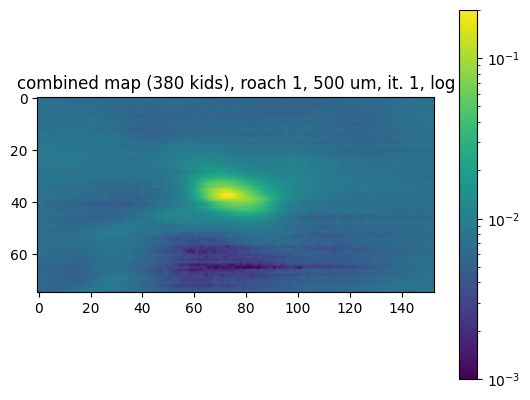

In [111]:
iter_1_path = pathFromLocal('it_1', 'combined_map.npy')

img = np.load(iter_1_path)
# img: 3d numpy array (3 x 75 x 153)
    #    img[0] (-100,000 - 100,000) <- um offset (x) on sensor
    #    img[1] (-50,000, 50,000) <- um offset (y) on sensor
    #    img[2] (-0.01 - 0.197) <- signal strength, df

norm = colors.LogNorm(vmin=0.001, vmax=0.2)
plt.imshow(img[2]+0.008, norm=norm, cmap='viridis')
plt.colorbar()
plt.title("combined map (380 kids), roach 1, 500 um, it. 1, log")
plt.show()

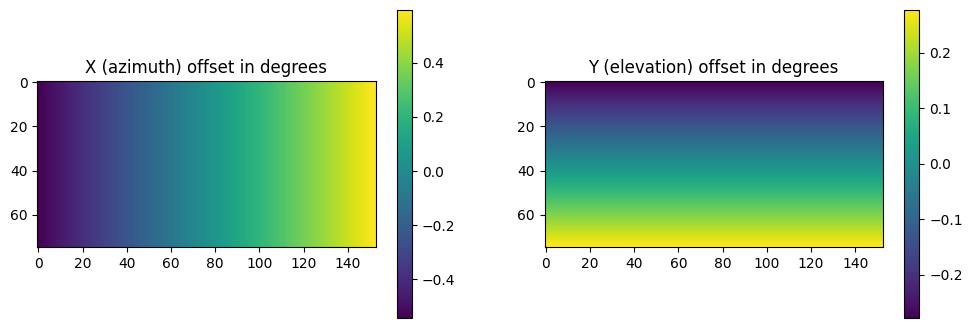

In [215]:
platescale = 5.9075e-6 # deg/um = 21.267 arcsec/mm

# inverted from mmi_map_lib.py
def offsetsTanProj(x_um, y_um, platescale):
    '''Convert image plane in um to offset in degrees.

    x, y: (1D array of floats) The offsets arrays in degrees.
    platescale: (float) Platescale in deg/um.
    '''
    
    from astropy.wcs import WCS
    
    w = WCS(naxis=2)
    w.wcs.crpix = [0, 0]   # center of the focal plane is tangent point
    w.wcs.crval = [0., 0.] # source is at center in offsets map
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    w.wcs.cdelt = [platescale, platescale]

    x_deg, y_deg = w.wcs_pix2world(x_um, y_um, 0)

    return x_deg, y_deg

x_offsets_deg, y_offsets_deg = offsetsTanProj(img[0], img[1], platescale)
x_offsets_deg[x_offsets_deg > 180] = x_offsets_deg[x_offsets_deg > 180] - 360  # small negative angles to fix discontinuity

_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(12, 4))
fig1 = ax1.imshow(x_offsets_deg,  cmap='viridis')
ax1.set_title("X (azimuth) offset in degrees")
plt.colorbar(fig1, ax=ax1)
fig2 = ax2.imshow(y_offsets_deg,  cmap='viridis')
ax2.set_title("Y (elevation) offset in degrees")
plt.colorbar(fig2, ax=ax2)
plt.show()

Takeoff (utc): 2020-01-06 05:10:00.000
RCW 92 Approx. Slice Time (utc): 2020-01-06 17:06:40.000


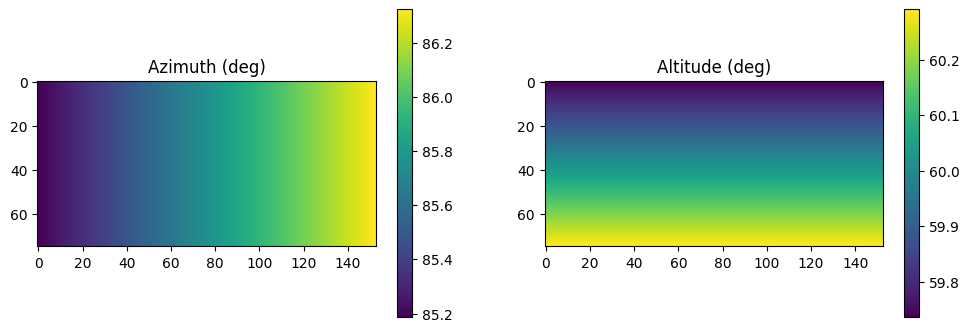

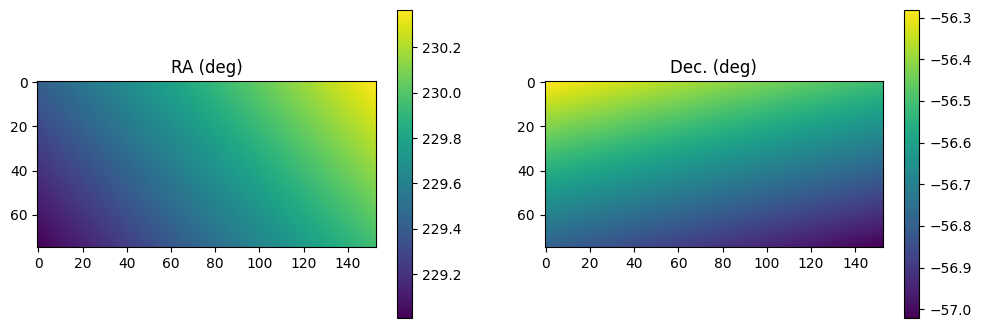

<SkyCoord (ICRS): (ra, dec) in deg
    [[(229.4158373 , -56.28187971), (229.42206601, -56.28340682),
      (229.42829491, -56.28493403), ..., (230.35226472, -56.51187456),
      (230.35852124, -56.51341387), (230.36477794, -56.51495325)],
     [(229.41037668, -56.28873986), (229.41660488, -56.29026692),
      (229.42283328, -56.29179406), ..., (230.34672946, -56.51872449),
      (230.35298549, -56.52026372), (230.3592417 , -56.52180302)],
     [(229.40491409, -56.29559979), (229.41114179, -56.29712679),
      (229.41736968, -56.29865387), ..., (230.34119219, -56.52557418),
      (230.34744773, -56.52711333), (230.35370345, -56.52865256)],
     ...,
     [(229.0175873 , -56.77519548), (229.02377896, -56.77671817),
      (229.02997082, -56.77824093), ..., (229.94853379, -57.00443863),
      (229.95475431, -57.00597234), (229.960975  , -57.00750612)],
     [(229.01198257, -56.78203796), (229.01817371, -56.78356058),
      (229.02436505, -56.78508328), ..., (229.94285139, -57.01127045),
  

In [214]:
# telescope position during RCW 92 slice, see map-making slide 31
rcw_92_min_lat = -77.110
rcw_92_max_lat = -77.070
rcw_92_min_lon = 162.20
rcw_92_max_lon = 162.55
rcw_92_min_alt = 36030
rcw_92_max_alt = 36120
rcw_92_avg_lat = rcw_92_min_lat/2. + rcw_92_max_lat/2.
rcw_92_avg_lon = rcw_92_min_lon/2. + rcw_92_max_lon/2.
rcw_92_avg_alt = rcw_92_min_alt/2. + rcw_92_max_alt/2.

rcw_92_avg_location = EarthLocation(lat=rcw_92_avg_lat*u.deg, lon=rcw_92_avg_lon*u.deg, height=rcw_92_avg_alt*u.m)


# "At 6:10 PM local time on January 6 of [2020], BLAST-TNG began its first flight"
# subtract 13h for UTC offset
takeoff_time = Time("2020-01-06 5:10:00", scale='utc')
rcw_approx_time_after_takeoff = 43_000  # seconds
rcw_92_time = takeoff_time+rcw_approx_time_after_takeoff*u.s
print(f"Takeoff (utc): {takeoff_time}")
print(f"RCW 92 Approx. Slice Time (utc): {rcw_92_time}")

# obtain absolute az/el
altaz_frame = AltAz(obstime=rcw_92_time, location=rcw_92_avg_location)
source_altaz = rcw92_coord.transform_to(altaz_frame)

abs_az = source_altaz.az + x_offsets_deg*u.deg
abs_alt = source_altaz.alt + y_offsets_deg*u.deg

_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(12, 4))
fig1 = ax1.imshow(abs_az.deg,  cmap='viridis')
ax1.set_title("Azimuth (deg)")
plt.colorbar(fig1, ax=ax1)
fig2 = ax2.imshow(abs_alt.deg,  cmap='viridis')
ax2.set_title("Altitude (deg)")
plt.colorbar(fig2, ax=ax2)
plt.show()

# ax2.set_title("Error")
# fig2 = ax2.imshow(error, cmap='viridis', origin='lower')
# plt.colorbar(fig2, ax=ax2, label="MJy/sr")

# Assume balloon has not travelled enough over time to impact coordinate conversion
onsky_coords = SkyCoord(alt=abs_alt, az=abs_az, obstime=rcw_92_time, frame='altaz', location=rcw_92_avg_location)

_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(12, 4))
fig1 = ax1.imshow(onsky_coords.icrs.ra.deg,  cmap='viridis')
ax1.set_title("RA (deg)")
plt.colorbar(fig1, ax=ax1)
fig2 = ax2.imshow(onsky_coords.icrs.dec.deg,  cmap='viridis')
ax2.set_title(("Dec. (deg)"))
plt.colorbar(fig2, ax=ax2)
plt.show()

onsky_coords.icrs